# Тестовое задание компания "ТЕХНЕЗИС"

**Описание:**

Тестовое задание на должность "Junior аналитик данных".

**Цель исследования:**

Необходимо обработать сырые данные, поступившие от парсера.


**Задачи:**

1. Собрать от каждой платформы финальный список гостиниц, в котором по каждой гостинице внутри платформы будет только одна запись с самыми актуальными и полными данными.
2. Почистить данные.
3. Поля телефона, email, сайтов распарсить и сохранить как списки в одинаковом формате ( address@domen.org, 79234553322, domen.ru)
4. Вывести топ 10 по каждой платформе, по параметрам:
    - больше всего телефонов,
    - больше всего отзывов.
5. Вывести квадрат координат размером 1км на 1км, где больше всего гостиниц.
6. Задача со *, объединить данные от двух платформ, по критерию, который вы придумаете:
    - Вывести все гостиницы, которые есть в платформе 1 и нет в платформе 2;
    - Вывести топ 10 гостиниц которые есть в обоих платформах, по суммарному количеству отзывов.



**Ход исследовия:**

- прочитать данные из файла и сохранить в датафремы;
- обзор и преобработка входных данных;
- выполнить задания;
- написать вывод.


## Описание данных

В файле [файл](https://disk.yandex.ru/d/pnJkHYsLcYF9gQ) с данными две вкладки platform1, platform2. Это данные о
гостиницах от двух разных платформ в одном регионе.


- `id` - Идентификатор в БД;
- `create_time` - Дата создания;
- `title` - Название;
- `hotel_type_original` - Тип гостиницы;
- `city` - Город;
- `address` - Адрес;
- `rating` - Рейтинг;
- `rating_5` - Рейтинг по 5-ти бальной шкале;
- `review_count` - Количество отзывов;
- `star_rating` - Звездность;
- `rooms_count` - Количество номеров;
- `contact_social` - Контакты соц. сетей;
- `description` - Описание;
- `email` - email строкой, несколько значений через запятую;
- `phone` - телефон строкой, несколько значений через запятую;
- `website` - сайты строкой, несколько значений через запятую;
- `uid` - Уникальный идентификатор гостиницы на платформе, не может быть разным у одной гостиницы, и не может повторятся у разных гостиниц, но в рамках одной платформы;
- `parsing_time` - Время сбора;
- `lat` - Широта;
- `lon` - Долгота;

## Настройка рабочей среды

In [3]:
# Подгрузка модулей
import pandas as pd
import requests
import json
import numpy as np
import re
import warnings

from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from io import BytesIO


## Глобальные переменные

In [4]:
url = 'https://disk.yandex.ru/d/pnJkHYsLcYF9gQ'

# Регулярное выражение для проверки валидных email
email_pattern = re.compile(r'^[a-zA-Z0-9._-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$')

# Регулярное выражение для проверки номера телефона
phone_pattern = re.compile(r'^(\+7|8)\d{10}$')

# Регулярное выражение для проверки URL
url_pattern = re.compile(
    r'^(https?://)?'
    r'^(www\.)?'
    r'([a-zA-Z0-9.-]+|[а-яА-Я0-9.-]+)'
    r'(\.[a-zA-Z]{2,}|\.рф)$'
)

# радиус Земли в километрах
earth_radius = 6371  

# Размер ячейки 1 км
cell_size_km = 1

city_translation = {
    'ufa': 'Уфа',
    'magnitogorsk': 'Магнитогорск',
    'sterlitamak': 'Стерлитамак',
    'beloretsk': 'Белорецк',
    'oktyabrskiy': 'Октябрьский',
    'neftekamsk': 'Нефтекамск',
    'salavat': 'Салават',
    'izhevsk': 'Ижевск',
    'kumertau': 'Кумертау'
}

# Установка параметров отображения pandas
pd.set_option('display.max_colwidth', None)

warnings.simplefilter("ignore", category=FutureWarning)

## Функции

### Функции предварительно обработки данных

#### Функция df_analysis()

Функция для предварительного общего анализа датафрейма.

In [5]:
# Функция для предварительного общего анализа датафрейма
def df_analysis(df):

    # Отображение датафрейма df
    display(df.head())
    print('*'*100)

    # Вывод основной информации о датафрейме df с помощью метода info().
    display(df.info())
    print('*'*100)

    # Проверка количества пропусков в датафрейме  df
    isna = df.isna().sum().reset_index(name='cnt').query('cnt > 0')
    if isna.shape[0] == 0:
        print('Пропусков в датафрейме нет.')  
    else:
        print('Пропуски в датафрейме:')  
        display(isna)
    print('*'*100)
    
    # Проверка количества дубликатов в датафрейме  df
    duplicated = df.duplicated().sum()
    print('Количество дубликатов в датафрейме: {}'.format(duplicated), end='')
    # Подсчет процента дубликатов в датафрейме df
    print(' ({:.2%} от общего количества записей).'.format(duplicated/df.shape[0]))    
    print('*'*100)


#### Функция df_column_astype()

Функция для преобразования типа данных у списка столбцов.

In [6]:
def df_column_astype(df, change_type):

    for column in change_type:
        df[column] = df[column].astype(change_type[column])


#### Функция df_duplicated_info()

Функция для поиска статистики по дубликатам в датафрейме.

In [7]:
def df_duplicated_info(df):
    # Проверка количества дубликатов в датафрейме  df
    cnt = df.duplicated().sum()

    print('Количество дубликатов в датафрейме: {0}'.format(cnt), end='')

    # Подсчет процента дубликатов в датафрейме df
    print(' ({:.2%} от общего количества записей).'.format(cnt/df.shape[0]))    

#### Функция get_direct_link()

Функция для получения прямой ссылки на файл


In [8]:
def get_direct_link(url):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key='
    final_url = base_url + url
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url


#### Функция df_isna_info()

Функция для поиска статистики по пропускам в датафрейме.

In [9]:
def df_isna_info(df):
    # Проверка количества пропусков в датафрейме  df
    isna = df.isna().sum().reset_index(name='cnt').query('cnt > 0')
    isna['percent'] = ((isna['cnt'] / len(df)) * 100).map(lambda x: f"{x:.2f}%")
    
    if isna.shape[0] == 0:
        print('Пропусков в датафрейме нет.')  
    else:
        print('Пропуски в датафрейме:')  
        display(isna)

#### Функция km_to_lat_lon()

Функция переводит из километров в широту и долготу относительно центра (lat0, lon0)

In [10]:
def km_to_lat_lon(x, y, lat0, lon0):

    lat0_rad = np.radians(lat0)
    lon0_rad = np.radians(lon0)
    
    lat = y / earth_radius + lat0_rad
    lon = x / (earth_radius * np.cos(lat0_rad)) + lon0_rad
    
    return np.degrees(lat), np.degrees(lon)


#### Функция lat_lon_to_km()

Функция переводит координаты широты и долготы в километры относительно центра (lat0, lon0)


In [11]:
def lat_lon_to_km(lat, lon, lat0, lon0):
 
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    lat0_rad = np.radians(lat0)
    lon0_rad = np.radians(lon0)
    
    x = earth_radius * (lon_rad - lon0_rad) * np.cos(lat0_rad)
    y = earth_radius * (lat_rad - lat0_rad)
    
    return x, y


#### Функция clean_address()

Функция для удаления города и страны из адреса и чистки строки

In [12]:
# Функция для удаления города и страны из адреса и чистки строки
def clean_address(row):
    
    address, city = row['address'], row['city']
    
    address = re.sub(
        r'\bРоссия\b|' 
        r'\bRussia\b|' 
        r'\bРеспублика\s+[А-Я][а-я]+\b|' 
        r'\b[А-Я][а-я]+\s+городской\s+округ\b', 
        '', address, flags=re.IGNORECASE
    )

    address = re.sub(
        rf'\b{city}\b', '', address, flags=re.IGNORECASE
    )
    
    # Удаляем лишние запятые и пробелы в начале и в конце строки
    address = re.sub(r'^[\s,]*|[\s,]*$', '', address)
    # Заменяем последовательности из запятых и пробелов на одну запятую и пробел
    address = re.sub(r',\s*,\s*', ', ', address)
    
    return address


#### Функция clean_description()

Функция для чистки комментариев

In [13]:
def clean_description(description):

    description = re.sub(r'<br\s*/?>(?:•\s*&nbsp;)*', ' ', description)
    description = description.replace('\n', ' ')
    return description



#### Функция is_valid_email()

Функция для проверки email на валидность

In [14]:
def is_valid_email(email):
    return bool(email_pattern.match(email))


#### Функция is_valid_phone()

Функция для проверки номера телефона на валидность

In [15]:
def is_valid_phone(phone):
    return bool(phone_pattern.match(phone))

#### Функция is_valid_url()

Функция для проверки url на валидность

In [16]:
def is_valid_url(row):
    url = row['website']
    if url.startswith('https://vk.com'):
        global socials
        new_record = pd.DataFrame([{'social': 'vk', 'contact': url, 'uid': row['uid']}])
        socials = pd.concat([socials, new_record], ignore_index=True)
    return bool(url_pattern.match(url))


### Функции для графического отображения информации

#### Функция draw_bar_horizontal()

Функция для построения горизонтальной столбчатой диаграммы

In [17]:
# Функция для горизонтальной столбчатой диаграммы
def draw_bar_horizontal(df, x, y, title, xlabel, ylabel, type=''):

    df = df.sort_values(by=y)
    
    # Построение графика
    ax = df.plot(
        kind='barh', 
        x=x,
        y=y,
        title=title, 
        xlabel=xlabel, 
        ylabel=ylabel, 
        figsize=(10, 5),
        grid=True, 
        legend=False,
    )

    # Добавляем значения внутри столбцов
    for p in ax.patches:
        
        get_width = str(p.get_width()) if type == '' else f'{p.get_width():.2f}%'
            
        ax.annotate(
            get_width, 
            (p.get_width(), p.get_y() + p.get_height() / 2),
            ha='left', 
            va='center', 
            xytext=(5, 0), 
            textcoords='offset points'
        )

    # Вывод графика
    plt.show()

## Загрузка данных и изучение общей информации

Загружаем данные с двух страниц каждую в отдельный датасет.

In [18]:
# Получение прямой ссылки на файл
download_url = get_direct_link(url)

# Загрузка файла и чтение его содержимого
response = requests.get(download_url)
file_content = BytesIO(response.content)

try:
    platform1 = pd.read_excel(file_content, sheet_name='platform1')
    platform2 = pd.read_excel(file_content, sheet_name='platfrom2')
except FileNotFoundError as e:
    print(f"FileNotFoundError successfully handled\n"
          f"{e}")

Заполняем проспуски в рамках группы uid, удаляем все, кроме послених строк.

In [19]:
# Сортировка DataFrame по 'uid' и 'parsing_time' и заполнение пропущенных значений с помощью 'ffill' и 'bfill'
platform1_new = platform1.sort_values(by=['uid', 'parsing_time']).groupby('uid').apply(lambda group: group.ffill().bfill()).reset_index(drop=True)

# Поиск максимальной даты parsing_time для каждой группы uid
max_dates = platform1_new.groupby('uid')['parsing_time'].transform('max')

# Оставить только строки с максимальной датой parsing_time для каждого uid
platform1_new = platform1_new[platform1_new['parsing_time'] == max_dates].reset_index(drop=True)


In [20]:
# Сортировка DataFrame по 'uid' и 'parsing_time' и заполнение пропущенных значений с помощью 'ffill' и 'bfill'
platform2_new = platform2.sort_values(by=['uid', 'parsing_time']).groupby('uid').apply(lambda group: group.ffill().bfill()).reset_index(drop=True)

# Поиск максимальной даты parsing_time для каждой группы uid
max_dates = platform2_new.groupby('uid')['parsing_time'].transform('max')

# Оставить только строки с максимальной датой parsing_time для каждого uid
platform2_new = platform2_new[platform2_new['parsing_time'] == max_dates].reset_index(drop=True)


Объединяем датасеты в один, для дальнейшей работы с ними. Маркируем записи принадлежностью к платформе.

In [21]:
data = pd.concat([platform1_new.assign(source=1), platform2_new.assign(source=2)], ignore_index=True)


## Предварительный анализ данных

In [22]:
df_analysis(data)

,id,create_time,title,hotel_type_original,city,address,rating,rating_5,review_count,region,...,contact_social,description,email,phone,website,uid,parsing_time,lat,lon,source
0,85495,2023-09-26 14:58:53.118918,Апартаменты рядом с Закхаймскими воротами,Apartment,Калининград,"Улица Черепичная 19В, Калининград",0.0,0.0,0.0,2,...,NaN,NaN,NaN,NaN,NaN,6292494,2023-09-26 20:56:02.013106,54.708366,20.534544,1
1,86914,2023-09-26 15:03:56.770665,Апартаменты на Мубарякова 10 корп. 1-1,Apartment,Уфа,"улица Мубарякова, д. 10, корп. 1, Уфа",0.0,0.0,0.0,2,...,NaN,NaN,NaN,NaN,NaN,6293892,2023-09-26 20:56:02.013106,54.695984,55.996050,1
2,86897,2023-09-26 15:03:53.226498,Апартаменты на Сагита Агиша 14 корпус 1,Apartment,Уфа,"улица Сагита Агиша, д. 14, корп. 1, Уфа",0.0,0.0,0.0,2,...,NaN,NaN,NaN,NaN,NaN,6293929,2023-09-26 20:56:02.013106,54.724865,56.007870,1
3,86912,2023-09-26 15:03:56.337687,Апартаменты на Мубарякова 10 корп. 1-2,Apartment,Уфа,"улица Мубарякова, д. 10, корп. 1, Уфа",0.0,0.0,0.0,2,...,NaN,NaN,NaN,NaN,NaN,6294009,2023-09-26 20:56:02.013106,54.696014,55.996020,1
4,86917,2023-09-26 15:03:57.413981,Апартаменты на Шафиева 8,Apartment,Уфа,"Улица Шафиева 8, Уфа",0.0,0.0,0.0,2,...,NaN,NaN,NaN,NaN,NaN,6294996,2023-09-26 20:56:02.013106,54.765140,55.997550,1


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6071 entries, 0 to 6070
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   6071 non-null   int64  
 1   create_time          6071 non-null   object 
 2   title                6071 non-null   object 
 3   hotel_type_original  6067 non-null   object 
 4   city                 5842 non-null   object 
 5   address              6071 non-null   object 
 6   rating               5942 non-null   float64
 7   rating_5             5942 non-null   float64
 8   review_count         5942 non-null   float64
 9   region               6071 non-null   int64  
 10  star_rating          428 non-null    float64
 11  rooms_count          1185 non-null   float64
 12  contact_social       251 non-null    object 
 13  description          35 non-null     

None

****************************************************************************************************
Пропуски в датафрейме:


,index,cnt
3,hotel_type_original,4
4,city,229
6,rating,129
7,rating_5,129
8,review_count,129
10,star_rating,5643
11,rooms_count,4886
12,contact_social,5820
13,description,6036
14,email,6042


****************************************************************************************************
Количество дубликатов в датафрейме: 0 (0.00% от общего количества записей).
****************************************************************************************************


## Предобработка данных


### Работа с пропусками

Преобразуем для всех значений название города в кириллицу, для удобства работы с датасетом.

In [23]:
data['city'] = data['city'].fillna('')


Оставшиеся пропуски заменим на значения по умолчанию, для удобства работы со значениями.

In [24]:
data['city'] = data['city'].apply(lambda x: city_translation.get(x, x))
data['hotel_type_original'] = data['hotel_type_original'].fillna('')

data['contact_social'] = data['contact_social'].fillna('')
data['description'] = data['description'].fillna('')
data['email'] = data['email'].fillna('')
data['phone'] = data['phone'].fillna('')
data['website'] = data['website'].fillna('')

data['rating'] = data['rating'].fillna(0)
data['rating_5'] = data['rating_5'].fillna(0)

data['rooms_count'] = data['rooms_count'].fillna(0)
data['star_rating'] = data['star_rating'].fillna(0)
data['review_count'] = data['review_count'].fillna(0)
data['lat'] = data['lat'].fillna(0)
data['lon'] = data['lon'].fillna(0)

In [25]:
df_isna_info(data)

Пропусков в датафрейме нет.


### Преобразование типа данных

Для корректной работы с данными преобразуем типы данных на соотвествующие значениям.

In [26]:
df_column_astype(
    data, 
    {
        'contact_social' : 'object',
        'description' : 'object',
        'email' : 'object',
        'phone' : 'object',
        'website' : 'object',
        'rooms_count' : 'int',
        'star_rating' : 'int',
        'review_count' : 'int',
    }
)

In [27]:
data['create_time'] = pd.to_datetime(data['create_time'])
data['parsing_time'] = pd.to_datetime(data['parsing_time'])

### Удаление столбцов

Удалим неиспользующиеся столбцы. ID - идентификатор в эксель таблицы, region по всем записям равен двум.

In [28]:
data = data.drop(['id', 'region'], axis=1)

### Работа с дубликатами

Явных дубликатов нет, это логично, потому что на предварительном этапе мы от них избавились.

In [29]:
df_duplicated_info(data)

Количество дубликатов в датафрейме: 0 (0.00% от общего количества записей).


На всякий случай убедимся в этом, посчитаем количество строк по каждой из uid.

In [30]:
data['uid'].value_counts()

uid
6292494              1
10365163             1
10367503             1
10367502             1
10367501             1
                    ..
9999791              1
9999786              1
9999785              1
9999761              1
70030076307422187    1
Name: count, Length: 6071, dtype: int64

### Результат предобработки данных

In [31]:
df_analysis(data)

,create_time,title,hotel_type_original,city,address,rating,rating_5,review_count,star_rating,rooms_count,contact_social,description,email,phone,website,uid,parsing_time,lat,lon,source
0,2023-09-26 14:58:53.118918,Апартаменты рядом с Закхаймскими воротами,Apartment,Калининград,"Улица Черепичная 19В, Калининград",0.0,0.0,0,0,1,,,,,,6292494,2023-09-26 20:56:02.013106,54.708366,20.534544,1
1,2023-09-26 15:03:56.770665,Апартаменты на Мубарякова 10 корп. 1-1,Apartment,Уфа,"улица Мубарякова, д. 10, корп. 1, Уфа",0.0,0.0,0,0,1,,,,,,6293892,2023-09-26 20:56:02.013106,54.695984,55.996050,1
2,2023-09-26 15:03:53.226498,Апартаменты на Сагита Агиша 14 корпус 1,Apartment,Уфа,"улица Сагита Агиша, д. 14, корп. 1, Уфа",0.0,0.0,0,0,0,,,,,,6293929,2023-09-26 20:56:02.013106,54.724865,56.007870,1
3,2023-09-26 15:03:56.337687,Апартаменты на Мубарякова 10 корп. 1-2,Apartment,Уфа,"улица Мубарякова, д. 10, корп. 1, Уфа",0.0,0.0,0,0,1,,,,,,6294009,2023-09-26 20:56:02.013106,54.696014,55.996020,1
4,2023-09-26 15:03:57.413981,Апартаменты на Шафиева 8,Apartment,Уфа,"Улица Шафиева 8, Уфа",0.0,0.0,0,0,1,,,,,,6294996,2023-09-26 20:56:02.013106,54.765140,55.997550,1


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6071 entries, 0 to 6070
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   create_time          6071 non-null   datetime64[ns]
 1   title                6071 non-null   object        
 2   hotel_type_original  6071 non-null   object        
 3   city                 6071 non-null   object        
 4   address              6071 non-null   object        
 5   rating               6071 non-null   float64       
 6   rating_5             6071 non-null   float64       
 7   review_count         6071 non-null   int64         
 8   star_rating          6071 non-null   int64         
 9   rooms_count          6071 non-null   int64         
 10  contact_social       6071 non-null   object        
 11  description          6071 non-null   object   

None

****************************************************************************************************
Пропусков в датафрейме нет.
****************************************************************************************************
Количество дубликатов в датафрейме: 0 (0.00% от общего количества записей).
****************************************************************************************************


**Вывод**

Предобработка завершена. Данные предоставлены в хорошем качестве.

Для удобства работы:

- подкорректирован тип данных, согласно заявленным значениям;
- обработаны пропуски, для корректной работы pandas;
- удалены лишние столбцы;
- удалены дубликаты.

При организации сбора необходимо обратить внимание на то, что с платформы1 полностью не заполнены контактные данные гостиниц. 100% пропущенных значений. 

## Задачи

### Чистка данных

В адреса дублируется город, а так же есть данные о стране, регионе, удалим эти значения, поскольку они есть только в одном из датасетов.

In [32]:
data['address'] = data.apply(clean_address, axis=1)


Удалим лишние символы в описании.

In [33]:
data['description'] = data['description'].apply(clean_description)

### Контактные данные

Сформируем отдельно словари по контактам в соцсетях, телефонов, email-ов и вебсайтов. Создадим их отдельными словарями.

In [34]:
# Функция для разбора JSON-строк и создания новой таблицы
socials_list = []

for index, row in data.query('contact_social != ""')[['contact_social', 'uid']].iterrows():
    contacts = json.loads(row['contact_social'])
    uid = row['uid']
    for contact in contacts:
        socials_list.append({
            'social': contact['social'],
            'contact': contact['contact'],
            'uid': uid
        })

# Создаем DataFrame из списка
socials = pd.DataFrame(socials_list, columns=['social', 'contact', 'uid'])



In [35]:
emails_list = []

for index, row in data.query('email != ""')[['email', 'uid']].iterrows():
    emails = row['email'].split(',')
    uid = row['uid']
    for email in emails:
        emails_list.append({
            'email': email.strip(),
            'uid': uid
        })
        
emails = pd.DataFrame(emails_list, columns=['email', 'uid'])


In [36]:
print(emails[~emails['email'].apply(is_valid_email)])


Empty DataFrame
Columns: [email, uid]
Index: []


Все полученные email-ы имеют валидный формат записи, нет никаких лишних символов.

In [37]:
phones_list = []

for index, row in data.query('phone != ""')[['phone', 'uid']].iterrows():
    phones = row['phone'].split(',')
    uid = row['uid']
    for phone in phones:
        cleaned_phone = phone.strip().replace('8', '+7', 1) if phone.strip().startswith('8') else phone.strip()
        phones_list.append({
            'phone': cleaned_phone,
            'uid': uid
        })


# Создаем DataFrame из списка
phones = pd.DataFrame(phones_list, columns=['phone', 'uid'])


In [38]:
print(phones[~phones['phone'].apply(is_valid_phone)])


Empty DataFrame
Columns: [phone, uid]
Index: []


Все телефонные номера имеют правильный формат записи.

In [39]:
websites = data.query('website != ""')[['website', 'uid']]

In [40]:
websites[~websites.apply(is_valid_url, axis=1)]['website'].unique()

array(['Забронировать', 'Перейти на сайт',
       'https://vk.com/bannaya_usadba11', 'Наша вкусная еда. Посмотреть',
       'Забронировать номер', 'Забронировать номер онлайн',
       'Подробнее здесь', 'Подробнее', 'Забронировать столик',
       'Как добраться'], dtype=object)

Есть неверная информация по данным о вебсайте. Инофмацию о vk перенесем в соотвествующий словарь, все остальное удалим, поскольку не имеет отношение к url.

In [41]:
# Добавляем столбец 'social' со значением 'vk'
vk_websites = websites[websites['website'].str.contains('vk.com', na=False)].rename(columns={'website': 'contact'})
vk_websites['social'] = 'vk'

# Объединяем с существующим DataFrame 'socials'
socials = pd.concat([socials, vk_websites], ignore_index=True)


In [42]:
websites = websites[websites.apply(is_valid_url, axis=1)]

Удалим столбцы, поскольку мы вынесли знаечния в словари

In [43]:
data = data.drop(['contact_social', 'email', 'phone', 'website'], axis=1)

Удалим дубли из словарей, поскольку в силу человеческого фактора значения могли дублироваться

In [44]:
emails = emails.drop_duplicates()

In [45]:
socials = socials.drop_duplicates()

In [46]:
websites = websites.drop_duplicates()

In [47]:
phones = phones.drop_duplicates()

### ТОП-10

#### По количеству уникальных телефонов

При заполнении пропусков мы выявили что по датасету 1 нет контактов, поэтмоу топ контактов у нас формируется только по второй платформе.

In [48]:
tmp = pd.merge(phones['uid'].value_counts().head(10).reset_index(), data[['title', 'city', 'uid']], on='uid', how='inner')
tmp['name'] = tmp['title']+'/'+tmp['city']
tmp

,uid,count,title,city,name
0,70000001045049293,4,"Vgosti, гостиница",Уфа,"Vgosti, гостиница/Уфа"
1,2393065583018400,2,"Нур, хостел",Уфа,"Нур, хостел/Уфа"
2,70000001067274899,2,"Куба, гостиница",Уфа,"Куба, гостиница/Уфа"
3,2393065583281479,2,"Белая река, придорожный комплекс",Уфа,"Белая река, придорожный комплекс/Уфа"
4,70000001065115999,2,Гостиничный комплекс,Уфа,Гостиничный комплекс/Уфа
5,70000001043849315,2,"Предгорье, гостиница",Стерлитамак,"Предгорье, гостиница/Стерлитамак"
6,70000001074945986,2,"Вояж, гостиница",Уфа,"Вояж, гостиница/Уфа"
7,70000001061154148,1,"Красный ключ, гостевой дом",Уфа,"Красный ключ, гостевой дом/Уфа"
8,70000001061410470,1,Малинkи,Магнитогорск,Малинkи/Магнитогорск
9,70000001061107069,1,"на Мраткино, мини-отель",Белорецк,"на Мраткино, мини-отель/Белорецк"


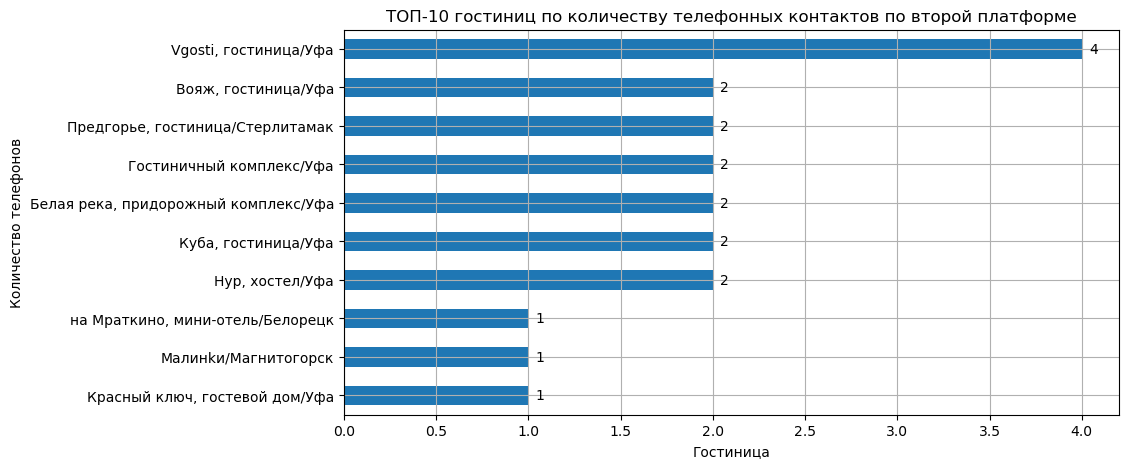

In [49]:
draw_bar_horizontal(
    tmp, 
    'name',
    'count',
    'ТОП-10 гостиниц по количеству телефонных контактов по второй платформе',
    'Гостиница',
    'Количество телефонов',
)

### По количеству отзывов

In [50]:
tmp = data.query("source == 1").sort_values(by='review_count', ascending=False).head(10)
tmp['name'] = tmp['title']+'/'+tmp['city']
tmp[['uid', 'review_count', 'title', 'city', 'name']]

,uid,review_count,title,city,name
386,7386924,1201,Radisson Blu Hotel Kaliningrad,Калининград,Radisson Blu Hotel Kaliningrad/Калининград
391,7403650,988,AZIMUT Сити Отель Уфа,Уфа,AZIMUT Сити Отель Уфа/Уфа
398,7467265,930,Отель Кайзерхоф (Kaiserhof),Калининград,Отель Кайзерхоф (Kaiserhof)/Калининград
540,7999515,837,Отель Ibis Калининград Центр,Калининград,Отель Ibis Калининград Центр/Калининград
34,6342481,616,Hilton Garden Inn Ufa Riverside,Уфа,Hilton Garden Inn Ufa Riverside/Уфа
465,7820894,540,Отель АМАКС Сити-отель,Уфа,Отель АМАКС Сити-отель/Уфа
226,6790074,460,Отель Hampton by Hilton Уфа,Уфа,Отель Hampton by Hilton Уфа/Уфа
3575,10159645,414,Гостиничный Комплекс Президент Отель,Уфа,Гостиничный Комплекс Президент Отель/Уфа
392,7405454,334,Гостиница Мартон Палас Калининград,Калининград,Гостиница Мартон Палас Калининград/Калининград
463,7816981,302,"Гостиница ""Шкиперская""",Калининград,"Гостиница ""Шкиперская""/Калининград"


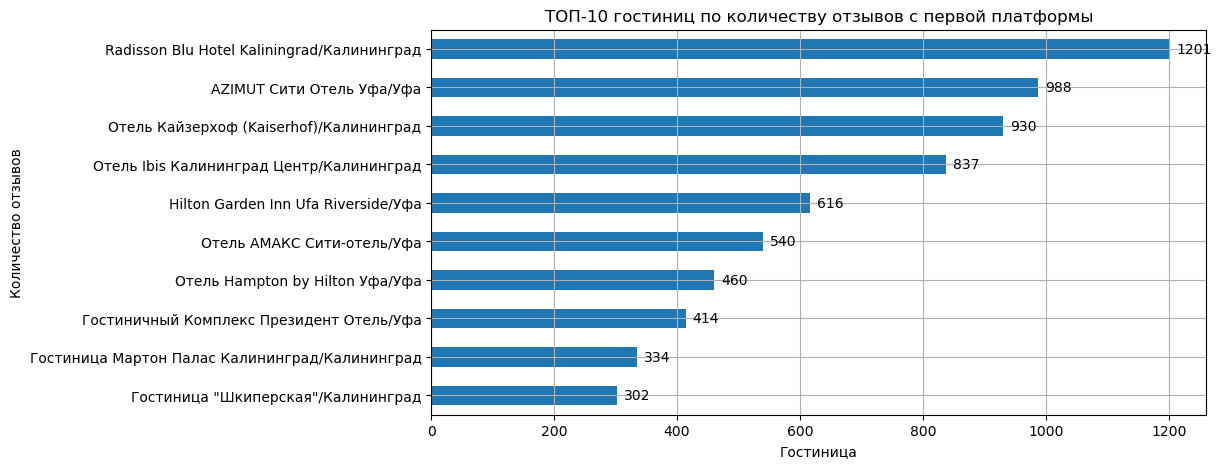

In [51]:
draw_bar_horizontal(
    tmp, 
    'name',
    'review_count',
    'ТОП-10 гостиниц по количеству отзывов с первой платформы',
    'Гостиница',
    'Количество отзывов',
)

In [52]:
tmp = data.query("source == 2").sort_values(by='review_count', ascending=False).head(10)
tmp['name'] = tmp['title']+'/'+tmp['city']
tmp[['uid', 'review_count', 'title', 'city', 'name']]

,uid,review_count,title,city,name
5625,70000001017323535,823,"Hilton Garden Inn Ufa Riverside, отель",Уфа,"Hilton Garden Inn Ufa Riverside, отель/Уфа"
5526,2393065583019903,780,"Башкирия, гостиничный комплекс",Уфа,"Башкирия, гостиничный комплекс/Уфа"
5635,70000001018632656,451,"Hampton by hilton Ufa, отель",Уфа,"Hampton by hilton Ufa, отель/Уфа"
5629,70000001017881800,416,"Урал тау, гостиничный комплекс",Уфа,"Урал тау, гостиничный комплекс/Уфа"
5525,2393065583019852,386,AZIMUT Сити Отель Уфа,Уфа,AZIMUT Сити Отель Уфа/Уфа
5531,2393065583022983,358,"Амакс Сити-отель, гостиница",Уфа,"Амакс Сити-отель, гостиница/Уфа"
5529,2393065583020265,341,"Президент отель, гостиничный комплекс",Уфа,"Президент отель, гостиничный комплекс/Уфа"
5631,70000001018312948,240,"Sheratonplaza Ufa Congress Hotel, гостиница",Уфа,"Sheratonplaza Ufa Congress Hotel, гостиница/Уфа"
5548,2393065583352950,232,"ВолнаСити, отель",Уфа,"ВолнаСити, отель/Уфа"
5547,2393065583315864,222,"Свояк, гостиничный комплекс",Уфа,"Свояк, гостиничный комплекс/Уфа"


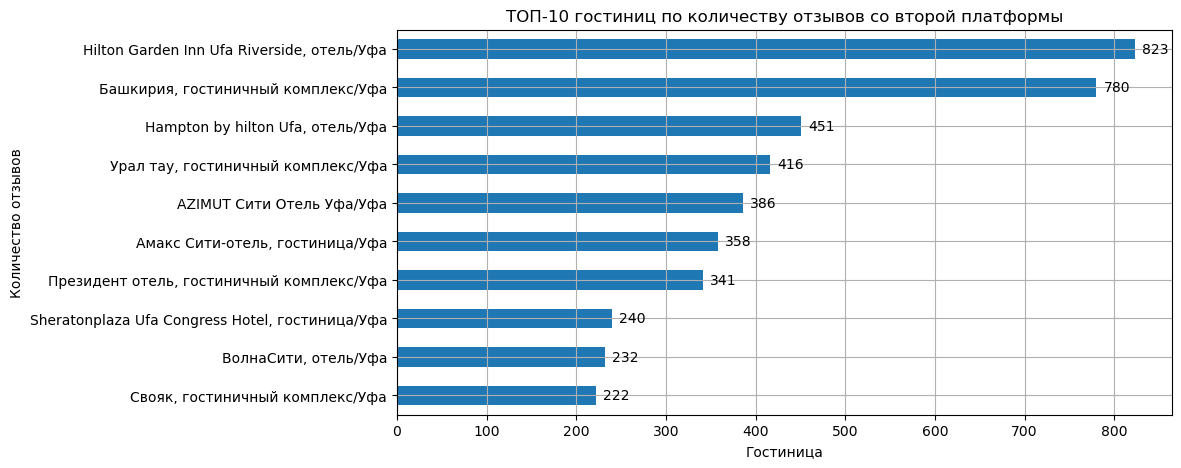

In [53]:
draw_bar_horizontal(
    tmp, 
    'name',
    'review_count',
    'ТОП-10 гостиниц по количеству отзывов со второй платформы',
    'Гостиница',
    'Количество отзывов',
)

### Квадрат координат с большим количеством гостиниц

Исключаем такие гостиницы, где координаты были не определены.

In [54]:
data.query('lat != 0')[['lat', 'lon', 'uid', 'source']]

,lat,lon,uid,source
0,54.708366,20.534544,6292494,1
1,54.695984,55.996050,6293892,1
2,54.724865,56.007870,6293929,1
3,54.696014,55.996020,6294009,1
4,54.765140,55.997550,6294996,1
...,...,...,...,...
6066,53.947493,57.061174,70000001078906834,2
6067,55.387737,56.652346,70000001079662007,2
6068,56.223245,55.930437,70000001079727477,2
6069,54.600768,53.696268,70030076144270841,2


In [55]:
# Формирование дополнительного среза с геолокациями всех отелей
geo = data[['lat', 'lon', 'uid', 'source']].reset_index()

# Выбор точки отсчета (медианный центр карты)
lat0, lon0 = geo['lat'].median(), geo['lon'].median()

# Преобразование широты и долготы в километры относительно точки отсчета
geo['x_km'], geo['y_km'] = zip(*geo.apply(lambda row: lat_lon_to_km(row['lat'], row['lon'], lat0, lon0), axis=1))

# Добавление столбцов для идентификаторов квадратов
geo['cell_x'] = (geo['x_km'] // cell_size_km).astype(int)
geo['cell_y'] = (geo['y_km'] // cell_size_km).astype(int)


In [56]:
# Подсчет количества гостиниц в каждом квадрате
cell_counts = geo.groupby(['cell_x', 'cell_y']).size().reset_index(name='counts')

# Ячейка с максимальным количеством гостиниц
max_count_cell = cell_counts.loc[cell_counts['counts'].idxmax()]

# Координаты границ этой ячейки
max_cell_x, max_cell_y = max_count_cell['cell_x'], max_count_cell['cell_y']

# Координаты границ ячейки (в километрах относительно точки отсчета)
xmin, xmax = max_cell_x * cell_size_km, (max_cell_x + 1) * cell_size_km
ymin, ymax = max_cell_y * cell_size_km, (max_cell_y + 1) * cell_size_km

# Преобразование координат углов ячейки обратно в широту и долготу
lat_min, lon_min = km_to_lat_lon(xmin, ymin, lat0, lon0)
lat_max, lon_max = km_to_lat_lon(xmax, ymax, lat0, lon0)

message = f"""
Границы квадрата с максимальным количеством гостиниц
    Юго-западный угол: ({lat_min}, {lon_min})
    Северо-восточный угол: ({lat_max}, {lon_max})

Количество гостиниц: {max_count_cell['counts']}
    """

print(message)



Границы квадрата с максимальным количеством гостиниц
    Юго-западный угол: (54.954097401479686, 20.48151246246247)
    Северо-восточный угол: (54.963090617538874, 20.497086731231235)

Количество гостиниц: 267
    


Больше всего гостиниц расположено в Зеленоградске, Калининградская обл.

### Список гостиниц по каждой платформе

Для отображения информации по платформе сформируем строки со значениями из словарей, если значений больше  одного, запишем их через запятую.

In [57]:
emails_grouped = emails.groupby('uid')['email'].apply(lambda x: ', '.join(x)).reset_index()
phones_grouped = phones.groupby('uid')['phone'].apply(lambda x: ', '.join(x)).reset_index()
socials_grouped = socials.groupby('uid')['contact'].apply(lambda x: ', '.join(x)).reset_index()
websites_grouped = websites.groupby('uid')['website'].apply(lambda x: ', '.join(x)).reset_index()


Соединим таблицу со словарями

In [58]:
data = data.merge(emails_grouped, on='uid', how='left')
data = data.merge(phones_grouped, on='uid', how='left')
data = data.merge(socials_grouped, on='uid', how='left')
data = data.merge(websites_grouped, on='uid', how='left')

data

,create_time,title,hotel_type_original,city,address,rating,rating_5,review_count,star_rating,rooms_count,description,uid,parsing_time,lat,lon,source,email,phone,contact,website
0,2023-09-26 14:58:53.118918,Апартаменты рядом с Закхаймскими воротами,Apartment,Калининград,Улица Черепичная 19В,0.0,0.0,0,0,1,,6292494,2023-09-26 20:56:02.013106,54.708366,20.534544,1,NaN,NaN,NaN,NaN
1,2023-09-26 15:03:56.770665,Апартаменты на Мубарякова 10 корп. 1-1,Apartment,Уфа,"улица Мубарякова, д. 10, корп. 1",0.0,0.0,0,0,1,,6293892,2023-09-26 20:56:02.013106,54.695984,55.996050,1,NaN,NaN,NaN,NaN
2,2023-09-26 15:03:53.226498,Апартаменты на Сагита Агиша 14 корпус 1,Apartment,Уфа,"улица Сагита Агиша, д. 14, корп. 1",0.0,0.0,0,0,0,,6293929,2023-09-26 20:56:02.013106,54.724865,56.007870,1,NaN,NaN,NaN,NaN
3,2023-09-26 15:03:56.337687,Апартаменты на Мубарякова 10 корп. 1-2,Apartment,Уфа,"улица Мубарякова, д. 10, корп. 1",0.0,0.0,0,0,1,,6294009,2023-09-26 20:56:02.013106,54.696014,55.996020,1,NaN,NaN,NaN,NaN
4,2023-09-26 15:03:57.413981,Апартаменты на Шафиева 8,Apartment,Уфа,Улица Шафиева 8,0.0,0.0,0,0,1,,6294996,2023-09-26 20:56:02.013106,54.765140,55.997550,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6066,2023-09-29 15:27:47.123060,"Культамак, туристическая база",hotel_rest,,Гафурийский район,0.0,0.0,0,0,0,,70000001078906834,2023-09-29 22:25:22.312234,53.947493,57.061174,2,NaN,NaN,NaN,NaN
6067,2023-09-29 15:27:26.345851,Goldy Land,hotel,Уфа,"Нуримановский район, с. Красный Ключ, Матросова, 51",0.0,0.0,0,0,0,,70000001079662007,2023-09-29 22:24:58.823852,55.387737,56.652346,2,NaN,+79674537238,NaN,NaN
6068,2023-09-29 15:27:35.414340,"Уют, гостиница",hotel,,"Татышлинский район, с. Новые Татышлы, Школьная, 27",0.0,0.0,0,0,0,,70000001079727477,2023-09-29 22:25:08.827319,56.223245,55.930437,2,NaN,+79373430037,NaN,NaN
6069,2023-09-29 15:27:15.898333,Гостиница,,Уфа,"Туймазинский район, Туймазы",0.0,0.0,0,0,0,,70030076144270841,2023-09-29 22:24:47.210166,54.600768,53.696268,2,NaN,NaN,NaN,NaN


Списко гостиниц с первой платформы.

In [59]:
data1 = (
    data.query('source == 1')[[
        'create_time',
        'title',
        'hotel_type_original',
        'city',
        'address',
        'rating',
        'rating_5',
        'review_count',
        'star_rating',
        'rooms_count',
        'description',
        'email',
        'phone',
        'contact',
        'website',
        'uid',
        'parsing_time',
        'lat',
        'lon'
    ]]
)

data1

,create_time,title,hotel_type_original,city,address,rating,rating_5,review_count,star_rating,rooms_count,description,email,phone,contact,website,uid,parsing_time,lat,lon
0,2023-09-26 14:58:53.118918,Апартаменты рядом с Закхаймскими воротами,Apartment,Калининград,Улица Черепичная 19В,0.0,0.0,0,0,1,,NaN,NaN,NaN,NaN,6292494,2023-09-26 20:56:02.013106,54.708366,20.534544
1,2023-09-26 15:03:56.770665,Апартаменты на Мубарякова 10 корп. 1-1,Apartment,Уфа,"улица Мубарякова, д. 10, корп. 1",0.0,0.0,0,0,1,,NaN,NaN,NaN,NaN,6293892,2023-09-26 20:56:02.013106,54.695984,55.996050
2,2023-09-26 15:03:53.226498,Апартаменты на Сагита Агиша 14 корпус 1,Apartment,Уфа,"улица Сагита Агиша, д. 14, корп. 1",0.0,0.0,0,0,0,,NaN,NaN,NaN,NaN,6293929,2023-09-26 20:56:02.013106,54.724865,56.007870
3,2023-09-26 15:03:56.337687,Апартаменты на Мубарякова 10 корп. 1-2,Apartment,Уфа,"улица Мубарякова, д. 10, корп. 1",0.0,0.0,0,0,1,,NaN,NaN,NaN,NaN,6294009,2023-09-26 20:56:02.013106,54.696014,55.996020
4,2023-09-26 15:03:57.413981,Апартаменты на Шафиева 8,Apartment,Уфа,Улица Шафиева 8,0.0,0.0,0,0,1,,NaN,NaN,NaN,NaN,6294996,2023-09-26 20:56:02.013106,54.765140,55.997550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5517,2023-09-26 15:00:16.295934,Квартира Королевские ворота,Apartment,Калининград,"улица 1812 года, д. 126",0.0,0.0,0,0,0,,NaN,NaN,NaN,NaN,10845316,2023-09-26 20:56:02.013106,54.711185,20.536673
5518,2023-09-26 15:00:16.511719,Апартаменты Трехкомнатные Pro.apartment на Приморской,Apartment,Зеленоградск,"улица Приморская, д. 35",0.0,0.0,0,0,0,,NaN,NaN,NaN,NaN,10845334,2023-09-26 20:56:02.013106,54.951103,20.458860
5519,2023-09-26 15:05:10.023309,Квартира SeverApart,Apartment,Уфа,"улица Октябрьской Революции, д. 23А",0.0,0.0,0,0,0,,NaN,NaN,NaN,NaN,10845801,2023-09-26 20:56:02.013106,54.722687,55.954900
5520,2023-09-26 15:00:16.723787,Квартира на Сельме,Apartment,Калининград,"улица Маршала Жукова, д. 10",0.0,0.0,0,0,0,,NaN,NaN,NaN,NaN,10846072,2023-09-26 20:56:02.013106,54.750538,20.492044


Список гостиниц со второй платформы.

In [60]:
data2 = (
    data.query('source == 2')[[
        'create_time',
        'title',
        'hotel_type_original',
        'city',
        'address',
        'rating',
        'rating_5',
        'review_count',
        'star_rating',
        'rooms_count',
        'description',
        'email',
        'phone',
        'contact',
        'website',
        'uid',
        'parsing_time',
        'lat',
        'lon'
    ]]
)

data2

,create_time,title,hotel_type_original,city,address,rating,rating_5,review_count,star_rating,rooms_count,description,email,phone,contact,website,uid,parsing_time,lat,lon
5522,2023-09-29 15:27:18.405798,"Нур, хостел",hotel,Уфа,"Октябрьский район, Уфимское шоссе, 18",4.0,4.0,84,0,7,,NaN,"+79061002225, +79311065039",NaN,NaN,2393065583018400,2023-09-29 22:24:49.875294,54.783271,56.047044
5523,2023-09-29 15:25:50.163806,"Клеопатра, гостиница",hotel,Уфа,"Ленинский район, Коммунистическая, 53",4.9,4.9,30,4,30,,NaN,+73472734100,NaN,NaN,2393065583019098,2023-09-29 22:23:14.044904,54.726386,55.946670
5524,2023-09-29 15:25:39.479348,"Агидель, гостиница",hotel,Уфа,"Кировский район, Ленина, 16",3.7,3.7,189,3,150,,NaN,+73472680008,NaN,agidelhotel.ru,2393065583019835,2023-09-29 22:23:04.301298,54.722958,55.946230
5525,2023-09-29 15:25:38.779367,AZIMUT Сити Отель Уфа,hotel,Уфа,"Орджоникидзевский район, Октября проспект, 81",4.1,4.1,386,4,190,,NaN,+73472359000,NaN,azimuthotels.com,2393065583019852,2023-09-29 22:23:03.777296,54.773961,56.026270
5526,2023-09-29 15:25:37.371242,"Башкирия, гостиничный комплекс",hotel,Уфа,"Ленинский район, Ленина, 25/29",4.8,4.8,780,4,211,,NaN,+73472790000,https://vk.com/public56812758,www.gkbashkortostan.ru,2393065583019903,2023-09-29 22:23:02.714399,54.730703,55.949172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6066,2023-09-29 15:27:47.123060,"Культамак, туристическая база",hotel_rest,,Гафурийский район,0.0,0.0,0,0,0,,NaN,NaN,NaN,NaN,70000001078906834,2023-09-29 22:25:22.312234,53.947493,57.061174
6067,2023-09-29 15:27:26.345851,Goldy Land,hotel,Уфа,"Нуримановский район, с. Красный Ключ, Матросова, 51",0.0,0.0,0,0,0,,NaN,+79674537238,NaN,NaN,70000001079662007,2023-09-29 22:24:58.823852,55.387737,56.652346
6068,2023-09-29 15:27:35.414340,"Уют, гостиница",hotel,,"Татышлинский район, с. Новые Татышлы, Школьная, 27",0.0,0.0,0,0,0,,NaN,+79373430037,NaN,NaN,70000001079727477,2023-09-29 22:25:08.827319,56.223245,55.930437
6069,2023-09-29 15:27:15.898333,Гостиница,,Уфа,"Туймазинский район, Туймазы",0.0,0.0,0,0,0,,NaN,NaN,NaN,NaN,70030076144270841,2023-09-29 22:24:47.210166,54.600768,53.696268


### Объединение данных с двух платформ

In [61]:
pd.merge(data.query('source == 1'), data.query('source == 2'), on=['city', 'title'], how='inner')[['title', 'uid_x', 'uid_y', 'address_x', 'address_y', 'lon_x', 'lat_x', 'lon_y', 'lat_y']]

,title,uid_x,uid_y,address_x,address_y,lon_x,lat_x,lon_y,lat_y
0,AZIMUT Сити Отель Уфа,7403650,2393065583019852,"пр-т Октября, д. 81","Орджоникидзевский район, Октября проспект, 81",56.025784,54.774017,56.026270,54.773961
1,Малый отель на Черниковской,8417803,70000001024370385,"Черниковская ул., д. 51","Калининский район, Черниковка, Черниковская, 51",56.118767,54.807583,56.118155,54.807821
2,Малый отель на Черниковской,9986702,70000001024370385,"Черниковская улица, д.51","Калининский район, Черниковка, Черниковская, 51",56.118340,54.807750,56.118155,54.807821


In [62]:
data.query('uid == 8417803 or uid == 9986702')

,create_time,title,hotel_type_original,city,address,rating,rating_5,review_count,star_rating,rooms_count,description,uid,parsing_time,lat,lon,source,email,phone,contact,website
625,2023-09-26 15:00:28.820698,Малый отель на Черниковской,Hotel,Уфа,"Черниковская ул., д. 51",9.4,4.70,0,0,11,,8417803,2023-09-26 20:56:02.013106,54.807583,56.118767,1,NaN,NaN,NaN,NaN
1447,2023-09-26 15:02:17.535145,Малый отель на Черниковской,Hotel,Уфа,"Черниковская улица, д.51",8.9,4.45,0,0,0,,9986702,2023-09-26 20:56:02.013106,54.807750,56.118340,1,NaN,NaN,NaN,NaN


Нашла только 2 совпадения, попутно нашла неявный дубликат в списке на второй платформе, возможно проблема в формировании uid, либо это разные мини-отели. Гео-локации все таки отличаются

In [63]:
pd.merge(data.query('source == 1'), data.query('source == 2'), on=['lon', 'lat'], how='inner')

,create_time_x,title_x,hotel_type_original_x,city_x,address_x,rating_x,rating_5_x,review_count_x,star_rating_x,rooms_count_x,...,star_rating_y,rooms_count_y,description_y,uid_y,parsing_time_y,source_y,email_y,phone_y,contact_y,website_y


По гео-локациям не нашла ни одного совпадения с двух разных платформ.

## Общий вывод

Все задания выполнены. Жду результатов проверки.

В рамках тестового задания я провела предварительный анализ данных, выполнила предобработку данных, выявила отсутствие контактной информации с первой платформы, на что стоит обратить внимание.

Также были выявлены пропущенные значения в других столбцах, например, в поле "город", что можно считать критичным. Возможно, его можно было бы определить по гео-координатам. Однако процент таких объявлений небольшой.

Наибольшее количество гостиниц и отелей расположено в районе города Зеленоградска, Калининградская область.

ТОП-отелей по самым частым отзывам: Hilton Garden Inn Ufa Riverside, отель/Уфа; Башкирия, гостиничный комплекс/Уфа; Radisson Blu Hotel Kaliningrad/Калининград; AZIMUT Сити Отель Уфа/Уфа; Отель Кайзерхоф (Kaiserhof)/Калининград; Отель Ibis Калининград Центр/Калининград.

Больше всего телефонных номеров у гостиницы - Vgosti, гостиница/Уфа.

Объединение данных по двум датасетам не дало значительных результатов, поскольку совпадений по геолокациям практически нет, за исключением нескольких совпавших отелей в Уфе. Также мне показалось странным, что в первом датасете есть отели с одинаковым адресом и названием, но разными uid. Возможно, на это тоже стоит обратить внимание при сборе информации парсером.